In [34]:
from qiskit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmqx2')
from qiskit.ignis.characterization.gates import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ibmqfactory.load_account:WARNING:2020-07-10 14:09:36,477: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
qubits = [0]
controls = [1]

In [ ]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=5, circlabel='mcal')
cal_job = qiskit.execute(meas_calibs, backend=backend, shots=8192)
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

#Calibration matrix for result C
raw_counts = job.result().get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(job.result())
mitigated_counts = mitigated_results.get_counts(0)

In [38]:
type(circuit)

list

In [36]:
"""
Taken from https://qiskit.org/documentation/apidoc/characterization.html
1 Qubit Amplitude Cal
"""

circuit, xdata = ampcal_1Q_circuits(15, qubits)
job = qiskit.execute(circuit, backend=backend, shots=8192)
plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1




<Figure size 720x432 with 0 Axes>

Mitigated Rotation Error on U2(0,0): -0.000451 rads


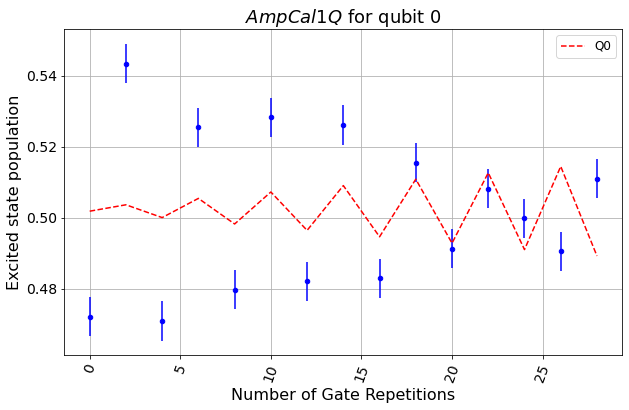

In [37]:
fit = AmpCalFitter(job.result(), xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

# plot the result for the number 1 indexed qubit.
# In this case that refers to Q2 since we passed in as [4, 2])
plt.figure(figsize=(10, 6))
fit.plot(0, ax=plt.gca())

print("Mitigated Rotation Error on U2(0,0): %f rads"%(fit.angle_err()[0]))
plt.show()

In [ ]:
# 1 Qubit Angle Cal
circuit, xdata = anglecal_1Q_circuits(75, qubits)
job = qiskit.execute(circuit, backend=backend, shots=8192)
plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalFitter(job.result(), xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())

print("Angle error between X and Y: %f rads"%(fit.angle_err()[0]))
plt.show()

In [3]:
circs, xdata = ampcal_cx_circuits(150, qubits, controls)
batch1 = circs[:75]
batch2 = circs[75:]
shots = 8192
backend_result1 = qiskit.execute(batch1, backend, shots=shots).result()
backend_result2 = qiskit.execute(batch2, backend, shots=shots).result()



ModelValidationError: "{'results': {75: {'_schema': ['Invalid input type.']}}}"

In [28]:
#concats the results
trunc_parameter = 150

total_result = result.Result.from_dict({'job_id': '5f0769f8c794e4001abdd9ea',
'date': '2020-07-09T19:09:03+00:00',
'backend_version': '2.0.6',
'header': {'backend_name': 'ibmqx2', 'backend_version': '2.0.6',},
'qobj_id': '3c5712aa-4503-4a86-8266-c2c8de128a52',
'success': True,
'backend_name': 'ibmqx2',
'results': [*backend_result1.to_dict()['results'], *backend_result2.to_dict()['results']][:trunc_parameter]})
prob1 = list(map(lambda x: (x['10'] + x['11'])/8192, total_result.get_counts()))

In [29]:
#Normal Processing of results

temp = total_result.to_dict()['results'].copy()
temp = list(map(lambda x: {'0x1': x['data']['counts']['0x1'] + x['data']['counts']['0x3'], 
                           '0x0': x['data']['counts']['0x0'] + x['data']['counts']['0x2']}, temp))
res = total_result.to_dict()['results']
real_results = total_result.to_dict().copy()
for i in range(len(res)):
    real_results['results'][i]['data']['counts'] = temp[i]
    
real_results = result.Result.from_dict(real_results)

In [30]:
#Get rid of any results where control qubit is not 1
temp = total_result.to_dict()['results'].copy()
temp = list(map(lambda x: {'0x1': x['data']['counts']['0x3'], 
                           '0x0': x['data']['counts']['0x2']}, temp))
res = total_result.to_dict()['results']
real_results = total_result.to_dict().copy()
for i in range(len(res)):
    real_results['results'][i]['data']['counts'] = temp[i]
for i in range(len(res)):
    real_results['results'][i]['shots'] = real_results['results'][i]['data']['counts']['0x1'] + \
    real_results['results'][i]['data']['counts']['0x0']
real_results = result.Result.from_dict(real_results)

Rotation Error on C0X1: 0.454498 rads


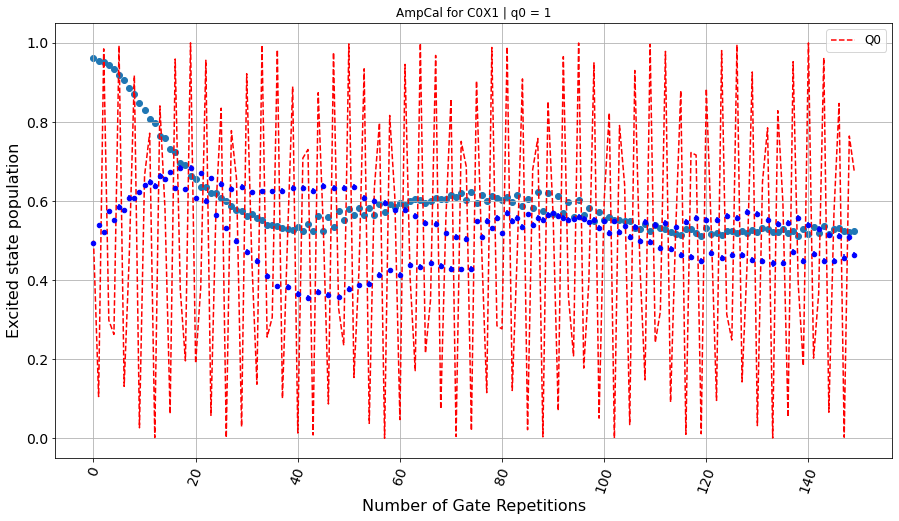

In [33]:

plt.figure(figsize=(15, 8))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AmpCalCXFitter(real_results, xdata[:trunc_parameter], qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
plt.scatter(xdata[:trunc_parameter], prob1)
plt.title('AmpCal for C0X1 | q0 = 1')
print("Rotation Error on C0X1: %f rads"%(fit.angle_err()[0]))
plt.show()